#CEM (Contrastive Explanation Method) on MNIST dataset :

CEM generates local black box explanations for classification models in terms of Pertinent Positives (PP) and Pertinent Negatives (PN).  For a PP, the method finds the necessary features that should be present to predict the same class as on the original instance. For, PN identifies what features should be necessarily absent from the instance to be explained in order to maintain the original prediction class. 

###Application of such explanations in healthcare-

A patient showing symptoms of fever, cough and cold but no chills will most likely be diagnosed as having flu rather than pneumonia. The presence of fever, cough and cold could indicate both flu or pneumonia. However, the absence of sputum or chills confirms the diagnosis of flu. 

In [ ]:
!pip install alibi

     |████████████████████████████████| 225kB 4.3MB/s 
     |████████████████████████████████| 327kB 7.1MB/s 
     |████████████████████████████████| 51kB 5.3MB/s 
     |████████████████████████████████| 28.0MB 147kB/s 
     |████████████████████████████████| 204kB 43.8MB/s 
  Created wheel for shap: filename=shap-0.36.0-cp36-cp36m-linux_x86_64.whl size=456459 sha256=9fd34e192804d4afc19ff6f86f8844108579fb14670e9a451e0c2d58f3213b1f
  Stored in directory: /root/.cache/pip/wheels/fb/15/e1/8f61106790da27e0765aaa6e664550ca2c50ea339099e799f4
  Created wheel for spacy-lookups-data: filename=spacy_lookups_data-0.1.0-py2.py3-none-any.whl size=28052144 sha256=481a1fb843d7066c4dacd931a5574ad9680f550387d359c9c14f8f26a1e18e58
  Stored in directory: /root/.cache/pip/wheels/2a/2b/0a/d6fb6235c56d014d224bca760d15d7cbdd820813085ffcd35d
Successfully built shap spacy-lookups-data


In [ ]:
import tensorflow as tf
tf.get_logger().setLevel(40) 
tf.compat.v1.disable_v2_behavior() 
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input, UpSampling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from alibi.explainers import CEM

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) 

TF version:  2.3.0
Eager execution enabled:  False


Loading the MNIST data:

11493376/11490434 [==============================] - 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)


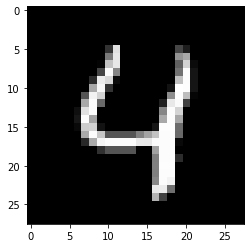

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[4]);

Prepare data: scale, reshape and categorize

In [ ]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train) #one-hot encoding using to_categorical
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [ ]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin) + xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

Now, training our CNN Model:

In [ ]:
def cnn_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
    x = MaxPooling2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x_out = Dense(10, activation='softmax')(x)

    cnn = Model(inputs=x_in, outputs=x_out)
    cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn

In [ ]:
cnn = cnn_model()
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=5, verbose=1)
cnn.save('mnist_cnn.h5', save_format='h5')

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 64)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 32)         

In [ ]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

Test accuracy:  0.9869


Training our Auto-encoder:

(Optional) An auto-encoder can be trained to reconstruct instances of the training set so that there is an L2 reconstruction error of the perturbed instance as an additional loss term. As a result, the perturbed instance lies close to the training data.

In [ ]:
def ae_model():
    x_in = Input(shape=(28, 28, 1))
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x_in)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    encoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    decoded = Conv2D(1, (3, 3), activation=None, padding='same')(x)

    autoencoder = Model(x_in, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

In [ ]:
ae = ae_model()
ae.summary()
ae.fit(x_train, x_train, batch_size=128, epochs=4, validation_data=(x_test, x_test), verbose=0)
ae.save('mnist_ae.h5', save_format='h5')

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 28, 16)        2320      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 1)         145       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 16)        160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 28, 28, 16)       

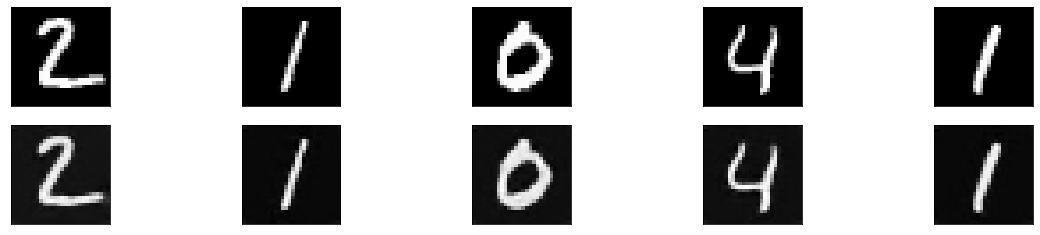

In [ ]:
ae = load_model('mnist_ae.h5')

decoded_imgs = ae.predict(x_test)
n = 5
plt.figure(figsize=(20, 4))
for i in range(1, n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

The first row depicts the original images while the second shows the decoded ones.

##Contrastive Explaination with pertinent negative:

Pertinent negatives (PN) are changed feature values found by changing the value of each feature away from its median such that the model prediction changes.

Since this is a local explanation, we have considered a particular instance - index 15.

In [ ]:
idx = 15
X = x_test[idx].reshape((1,) + x_test[idx].shape) #(1,28,28,1)

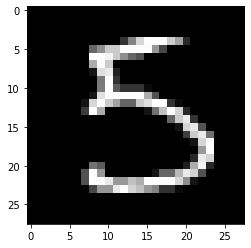

In [ ]:
plt.imshow(X.reshape(28, 28));

In [ ]:
cnn.predict(X).argmax(), cnn.predict(X).max()

(5, 0.9999682)

CEM parameters:

*   mode : 'PN' (Pertinent Negative) or 'PP' (Pertinent Positive)
*   shape : Shape of the current instance. As CEM is applicable for single explanations, we take 1 as the batch dimension which is added to the shape of data.
*   kappa, beta, gamma, c_init, c_steps are all mathematical terms for calculating loss
*   max_iterations : the total no. of loss optimization steps for each value of c
*   feature_range : global or feature wise minimum and maximum values for the changed instance
*   clip : minimum and maximum gradient values
*   lr_init : initial learning rate 



In [ ]:
mode = 'PN'  
shape = (1,) + x_train.shape[1:]  
kappa = 0. 
beta = .1 
gamma = 100  
c_init = 1.  
              
c_steps = 10 
max_iterations = 1000  
feature_range = (x_train.min(),x_train.max())  
clip = (-1000.,1000.)  
lr = 1e-2  
no_info_val = -1. 

In [ ]:
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent negative prediction: 8


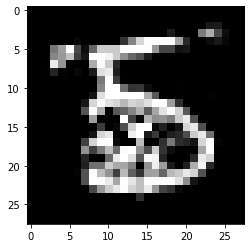

In [ ]:
print('Pertinent negative prediction: {}'.format(explanation.PN_pred))
plt.imshow(explanation.PN.reshape(28, 28))

INTERPRETATION -

The pixels with values close to 1 define the number in the image while the background pixels have value 0. We assume that perturbations towards the background value 0 are equivalent to removing features, while perturbations towards 1 imply adding features. Adding features to get a PN means changing 0’s into 1’s until a different number is formed, in this case changing a 5 into an 8. 

The pertinent negative prediction is 8. This means that on presence of some pixels(that are pertinent negative) , that should be absent, the prediction moves from 5 to 8(8 is close to and similar to 5).

The above image shows some PN pixels that should necessarily be absent from the image for model prediction to retain the prediction and not change to 8. 

##Contrastive Explaination with pertinent positive:

Pertinent positives (PP) are feature values obtained by changing the value of each feature towards its median such that the model prediction remains the same.

In [ ]:
mode = 'PP'

In [ ]:
cem = CEM(cnn, mode, shape, kappa=kappa, beta=beta, feature_range=feature_range,
          gamma=gamma, ae_model=ae, max_iterations=max_iterations,
          c_init=c_init, c_steps=c_steps, learning_rate_init=lr, clip=clip, no_info_val=no_info_val)

explanation = cem.explain(X)

Pertinent positive prediction: 5


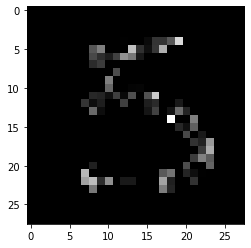

In [ ]:
print('Pertinent positive prediction: {}'.format(explanation.PP_pred))
plt.imshow(explanation.PP.reshape(28, 28));

INTERPRETATION -

For a PP, the model prediction remains the same and thus it is 5 same as the original prediction.

The above image highlight the important pixels (which look like a 5) that should be present for it to be classified as a 5. In other words, these pixels should be minimally and necessarily present for the model prediction to be 5.

In [ ]:
os.remove('mnist_cnn.h5')
os.remove('mnist_ae.h5')